# Four Models Example

Excerpts from supereeg tutorial using Kai Miller's data faces_basic

In [2]:
import supereeg as se
import os
import numpy as np
from scipy.io import loadmat
%matplotlib inline

## Load data from .mat files

This tutorial uses the faces_basic library without modifying the file structure. Modify this cell to match your file structure:

In [3]:
data_dir = '../miller_data/faces_basic/data/'
data_name = 'faceshouses.mat'
locs_dir = '../miller_data/faces_basic/locs/'
locs_name = 'xslocs.mat'

First we read the patient ids from the file structure. This is necessary to ensure we use matching data when constructing the brain objects.

In [4]:
ids = [x[:2] for x in os.listdir(data_dir) if x[0] != '.']
ids[0]

'jt'

Next we use scipy.io.loadmat to read the .mat files as dictionaries. 

In [5]:
data = {f'{x}': loadmat(f"{data_dir}{x}/{x}_{data_name}") for x in ids}
type(data['jt'])

dict

Since the only data we need from the xslocs.mat files are the electrode locations ('locs'), we append these data to our existing data dictionaries.

In [6]:
for x in ids:
    data[x]['locs'] = loadmat(f"{locs_dir}{x}_{locs_name}")['locs']

In [7]:
data['jt'].keys()

dict_keys(['__header__', '__version__', '__globals__', 'data', 'stim', 'srate', 'locs'])

We assume that the data and the locations share the same indices even though we can't be sure just from looking at the data.

## Building a brain object

Brain objects are supereeg’s fundamental data structure for a single subject’s ECoG data. To create one at minimum you’ll need a matrix of neural recordings (time samples by electrodes), electrode locations, and a sample rate. Additionally, you can include information about separate recording sessions and store custom meta data.

To construct a new brain object, simply pass the data and locations to the Brain class like this:

In [8]:
bos = [se.Brain(data = data[x]['data'], locs = data[x]['locs'], 
                sample_rate = data[x]['srate']) for x in ids]

To view a summary of the contents of the brain object, you can call the info function:

In [9]:
bos[0].info()

Number of electrodes: 102
Recording time in seconds: [[271.4]]
Sample Rate in Hz: [array([1000], dtype=uint16)]
Number of sessions: 1
Date created: Mon Jan 27 12:22:07 2025
Meta data: {}


You can plot both the data and the electrode locations:

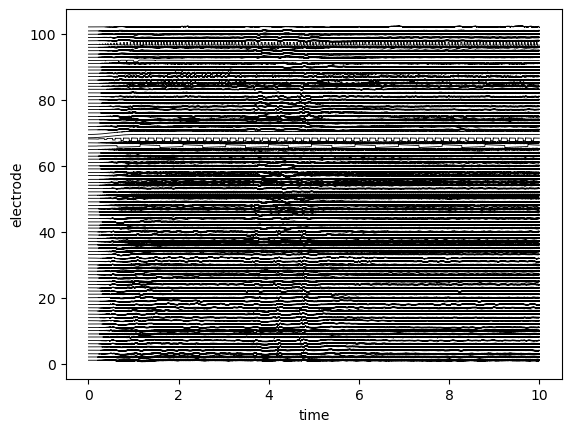

In [10]:
bos[0].plot_data()

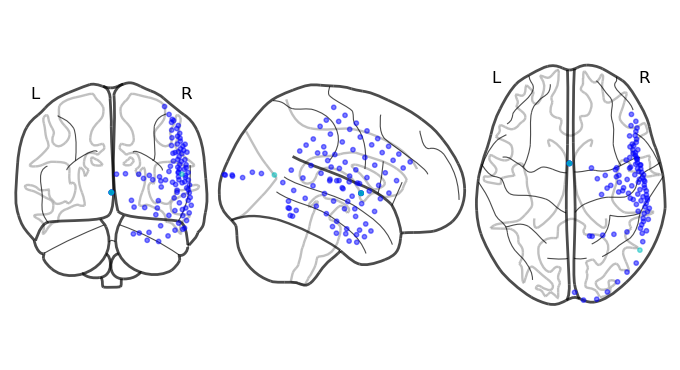

In [11]:
bos[0].plot_locs()

For more features and documentation please refer to the supereeg API and/or the tutorials.

## Model objects and predicting whole brain activity

Model objects are supereeg’s class that contains the correlation model that we use to reconstruct full-brain activity from recordings at an impoverished set of locations. The supereeg package offers a several pre-compiled models that you can use to reconstruct brain activity. We also provide several ways of creating or specifying your own model.

Model objects can be initialized by passing any of the following to the Model class instance initializer: 
- a path to an existing saved model object (ending in .mo)
- an existing model object (this makes a copy of the existing model object)
- a Brain object or Nifti object [or paths to saved Brain objects (.bo) or Nifti objects (.nii)]
- a string corresponding to any of the built-in example files, of any format (any datatype may be converted to a Model object)

In addition, new model objects may be created via the load function (which loads any of the toolbox-supported data types) and specifying return_type='mo'.

First let's build a model from the first three patients:

In [12]:
mo1 = se.Model(data = bos[:3], n_subs = 3)

We can get some info on the model object:

In [13]:
mo1.info()

Number of locations: 194
Number of subjects: 3
RBF width: 20
Date created: Mon Jan 27 12:22:15 2025
Meta data: {'stable': True}


And we can plot it too:

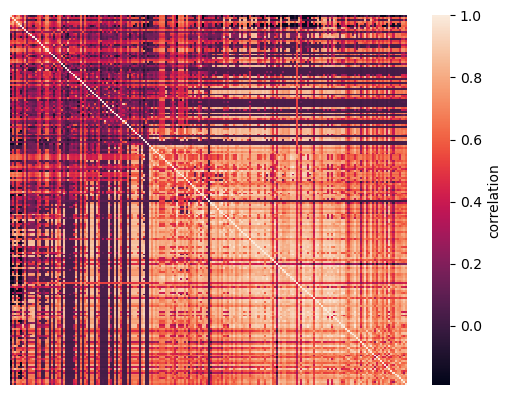

<Axes: >

In [14]:
mo1.plot_data(xticklabels=False, yticklabels=False)

The model is comprised of a number of fields. The most important are the model.numerator and model.denominator. Dividing these two fields gives a matrix of z-values, where the value in each cell represents the covariance between every model brain location with every other model brain location. To view the model, simply call the model.plot_data() method. This method wraps seaborn.heatmap to plot the model (transformed from z to r), so any arguments that seaborn.heatmap accepts are supported by model.plot.

We can also plot the electrode locations in the model:

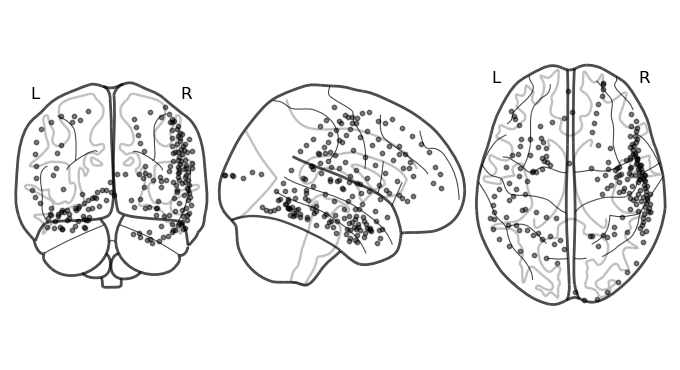

In [15]:
mo1.plot_locs()

Now let's make another model using the first six patients' data. We can do this several ways:
- initialize a new model
- update an existing model
- add existing models together

Let's use the addition method to create a new model with more data:

In [16]:
mo2 = mo1 + se.Model(data = bos[3:6], n_subs = 3)

In [17]:
mo2.info()

Number of locations: 290
Number of subjects: 6
RBF width: 20
Date created: Mon Jan 27 12:22:15 2025
Meta data: {'stable': True}


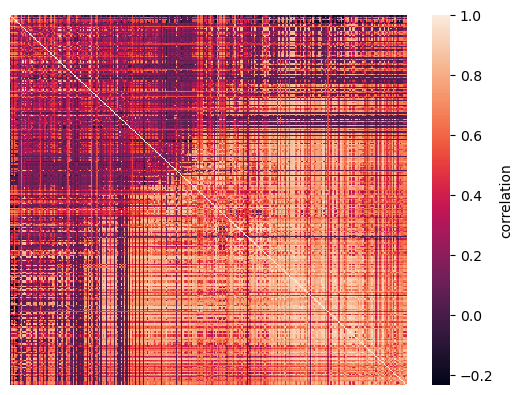

<Axes: >

In [18]:
mo2.plot_data(xticklabels=False, yticklabels=False)

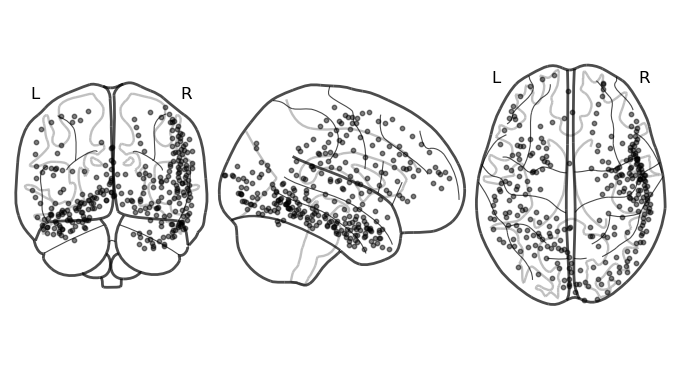

In [19]:
mo2.plot_locs()

## Comparing different models

Now let's make some models using different subsets of the same data and compare them. We'll continue using the faces_houses data (with the exception of patient 'jm' for technical reasons) but we'll also add in the faces_noisy data. This dataset includes the same faces_houses data of seven patients as well as responses from the same task with a noisy stimulus. 

We'll make four different models using particular sets of observations:

- The basic task data from the seven patients who performed both tasks
- The basic and noisy task data from the seven patients
- The basic task data from all thirteen patients
- All  the data

First, let's arrange our brain objects. We already have the data from the thirteen patients who completed the basic task:

In [25]:
basic13_bos = bos[:12] + bos[13:]

But before we can separate out the data from the seven patients who completed the basic task, we have to find out which seven patients those are. So let's load in the data for the noisy task like we did above: 

In [26]:
noisy_data_dir = '../miller_data/faces_noise/data/'
noisy_data_name = 'fhnoisy.mat'
noisy_locs_dir = '../miller_data/faces_noise/locs/'
noisy_locs_name = 'xslocs.mat'

noisy_ids = [x[:2] for x in os.listdir(noisy_data_dir) if x[0] != '.']

noisy_data = {f'{x}':loadmat(f"{noisy_data_dir}{x}/{x}_{noisy_data_name}") for x in noisy_ids}

for x in noisy_ids:
    noisy_data[x]['locs'] = loadmat(f"{noisy_locs_dir}{x}_{noisy_locs_name}")['locs']

Now we can sort out the basic task data of the seven patients who did both:

In [55]:
basic7_bos = [x for i,x in enumerate(bos) 
              if i in np.argwhere(np.isin(ids,noisy_ids))]

And we can make a list of brain objects from the noisy task data:

In [57]:
noisy7_bos = [se.Brain(data = noisy_data[x]['data'], locs = noisy_data[x]['locs'], 
                sample_rate = noisy_data[x]['srate']) for x in noisy_ids]

Now we're prepared to make some models in the same way as demonstrated above. This can take some time, so for convenience we can also load in the previously-saved models. 

In [ ]:
mo_basic7 = se.Model(data = basic7_bos, n_subs = len(basic7_bos))
mo_basic13 = se.Model(data = basic13_bos, n_subs = len(basic14_bos))
mo_noisy14 = mo_basic7

In [59]:
mo_basic7 = se.load('basic7.mo')
mo_noisy13 = se.load('noisy13.mo')
mo_basic13 = se.load('basic13.mo')
mo_all20 = se.load('all20.mo')

## Where to go from here

- make a script for leave-one-out analysis
- make various subsets of the patients/electrodes and analyze what is most informative